# AISEL -- Pedestrian Detector 
based on the PHD Thesis of Michael Greiffenhagen: "Engineering, Statistical Modeling and Performance Characterization of a Real-Time Dual Camera Surveillance System" Erlangen 2001
## Module 3: Indexing for Hypothesis Generation</p>

In [1]:
import os
import cv2
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.spatial import distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
%matplotlib notebook

In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/thraki/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

Load pedestrian video file from epfl from https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/.

## Part 1: Indexing for Hypothesis Generation
Generate regions of interests, where potential pedestrians could  be located with quantifiable probabilites for false alarm and miss detections

In [2]:
!wget https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/thraki/.wget-hsts'. HSTS will be disabled.
--2020-10-20 23:10:02--  https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi [following]
--2020-10-20 23:10:03--  https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi [following]
--2020-10-20 23:10:03--  https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi


In [3]:
file ='./epflpedestshort.avi?raw=true'
cap = cv2.VideoCapture(file)

In [4]:
import pyro
import torch


import pyro.infer
import pyro.optim
import pyro.distributions as dist

In [9]:
pyro.__version__

'1.4.0'

In [10]:
torch.__version__

'1.6.0'

In [7]:
pyro.set_rng_seed(101)



In [11]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [29]:
scale(12)

tensor(12.0788)

In [31]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

In [35]:
conditioned_scale(1)

9.5

In [36]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)

In [39]:
deferred_conditioned_scale(2,10)

2

In [40]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=9.5)

In [42]:
scale_obs(5)

9.5

In [15]:
def perfect_guide(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

In [47]:
perfect_guide(10)

tensor(8.9785)

In [49]:
def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(some_nonlinear_function(weight), 0.75))

In [50]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

In [51]:
scale_parametrized_guide(3)

tensor(9.1596, grad_fn=<AddBackward0>)

In [52]:
from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

In [55]:
scale_parametrized_guide_constrained(4)

tensor(8.2989, grad_fn=<AddBackward0>)

<IPython.core.display.Javascript object>


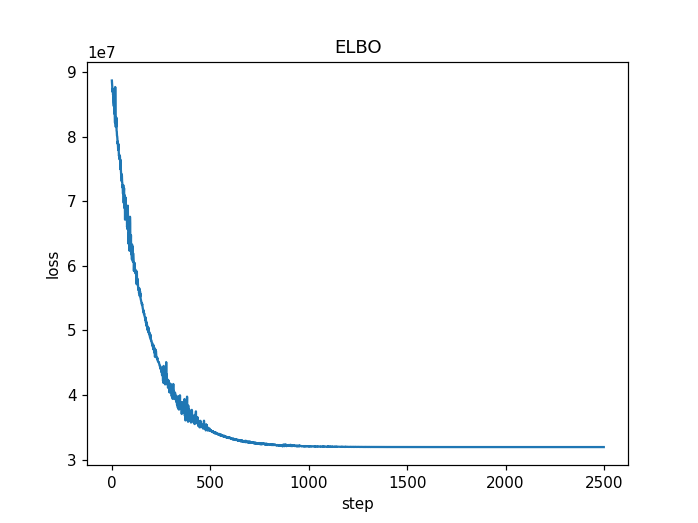

a =  3608.873046875
b =  0.6222198009490967


In [61]:
guess = 10000.

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

In [21]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

In Module 1 we introduced the illumination invariant normalised color channels r and g. We will use them as input to the background modelling.

In [5]:
def get_normalised_channels(img, pix=None):
    """Extract BGR channel of an image and return normalised r and g channels."""
    if pix:
        b,g,r = img[pix[0]][pix[1]]
    else:
        b,g,r = cv2.split(img)
    # Intensities are stored as int8, upcast for mathematical operations
    b = b.astype('int16');g = g.astype('int16');r = r.astype('int16')
    # Calculate vectorised sum over all channels
    rgb = np.add(r,np.add(b,g))
    # Calculate vectorised normalised channels
    r_norm = np.divide(r,rgb)
    g_norm = np.divide(g,rgb)
    return r_norm, g_norm

In [6]:
def get_cov(r_norm_vid, g_norm_vid):
    """Input wo matrices containing tuples, calulate elementwise the covariance and return the inverse of covariance matrices."""
    # Not vectorised for demo reasons, in production-> vectorise all numpy operations
    x,y = r_norm_vid[0].shape
    result = []
    last_inv_cov = None
    for i in range(x):
        for j in range(y):
            r_norm_pix = [r[i,j] for r in r_norm_vid]
            g_norm_pix = [g[i,j] for g in g_norm_vid]
            cov = np.cov(r_norm_pix,g_norm_pix)
            #cov = np.cov(r_norm_pix[~np.isnan(r_norm_pix)],g_norm_pix[~np.isnan(g_norm_pix)])
            ## hack to deal with non invertible cov matrices, replace with noise
            try:
                inv_cov =  np.linalg.inv(cov)
                last_inv_cov = inv_cov
            except:
                print("picked last cov mat @",i,j)
                inv_cov = last_inv_cov                          
            result.append(inv_cov)
    result = np.array(result)
    return result,(x,y)

In [7]:
def get_mahaldist(mu_b_arr,mu_c_arr,inv_cov_arr):
    "Returns mahalanobis distance measure for matrices of tuples and one matrix of 2X2 inverse covariance matrices"
    ## Not vectorised for demo reasons: In production-> vectorise all numpy operations
    x,y,z = mu_c.shape   
    result = []
    for i in range(x):
        for j in range(y):         
            d2 = distance.mahalanobis(mu_b_arr[i][j],mu_c_arr[i][j],inv_cov_arr[i][j])
            result.append(d2)
    return np.reshape(result,(x,y))


In [10]:
# containers to track evolution of mean
r_norm_vid = []; g_norm_vid = []

# limit frames to the first appearing in the video
i_frame=0
cap = cv2.VideoCapture(file)

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    # our main call to get normalised channels
    r_norm, g_norm  = get_normalised_channels(frame)
    
    r_norm_vid.append(r_norm)
    g_norm_vid.append(g_norm)
    
    i_frame=i_frame+1
    if i_frame>100: # limit frames to the first appearing in the video
        break
    

Now build our candidate for the background mean estimate $\mu_b$

In [11]:
mu_b = np.stack((np.nanmean(r_norm_vid,axis=0),np.nanmean(g_norm_vid,axis=0)),axis=2)

In [13]:
inv_cov_mat, cov_shape = get_cov(r_norm_vid, g_norm_vid)

picked last cov mat @ 6 61
picked last cov mat @ 32 13
picked last cov mat @ 32 14
picked last cov mat @ 32 29
picked last cov mat @ 32 30
picked last cov mat @ 32 58
picked last cov mat @ 33 10
picked last cov mat @ 33 26
picked last cov mat @ 33 28
picked last cov mat @ 34 10
picked last cov mat @ 34 15
picked last cov mat @ 34 30
picked last cov mat @ 34 31
picked last cov mat @ 35 25
picked last cov mat @ 35 29
picked last cov mat @ 35 31
picked last cov mat @ 35 61
picked last cov mat @ 36 5
picked last cov mat @ 36 14
picked last cov mat @ 36 15
picked last cov mat @ 37 7
picked last cov mat @ 37 27
picked last cov mat @ 37 31
picked last cov mat @ 38 6
picked last cov mat @ 38 12
picked last cov mat @ 38 45
picked last cov mat @ 38 47
picked last cov mat @ 38 51
picked last cov mat @ 39 2
picked last cov mat @ 39 31
picked last cov mat @ 40 26
picked last cov mat @ 40 56
picked last cov mat @ 40 61
picked last cov mat @ 41 22
picked last cov mat @ 41 39
picked last cov mat @ 41 

In [14]:
cov_mat_2d = np.reshape(inv_cov_mat, (cov_shape[0], cov_shape[1],2,2) )

In [21]:
## Loop over the video and save for constant mu_b and constant covariance matrix 
cap = cv2.VideoCapture(file)

d2_container = {}
mu_c_r_container = {}

i_frame = 0

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    if i_frame > 250:
        break
   
    r_norm, g_norm  = get_normalised_channels(frame)    
    
    mu_c = (r_norm, g_norm)
    mu_c = np.stack((r_norm,g_norm),axis=2)
    mu_c_r_container[i_frame] = mu_c
    
    d2 = get_mahaldist(mu_b,mu_c, cov_mat_2d)
    d2_container[i_frame] = d2
    
    i_frame = i_frame+1
    
    
cap.release()
cv2.destroyAllWindows()

In [22]:
# let pedestrians be 

<IPython.core.display.Javascript object>


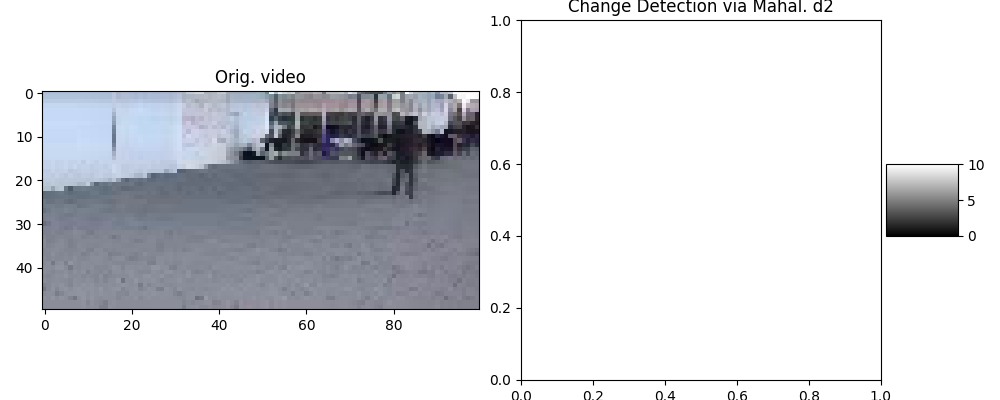

KeyError: 251

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10, 4))
i_frame = 0
cap = cv2.VideoCapture(file)

is_cb = False
success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    if i_frame > len(d2_container):
        break
   
    #frame = frame[x1:x2,y1:y2]    
    ax[0].set_title("Orig. video")
    ax[0].imshow(frame)
    # display original frame 
    ax[1].set_title('Change Detection via Mahal. d2')
    ax[1].set_xlabel('Dark values indicate background',fontsize=14)    
    
    ax_handle = ax[1].imshow(d2_container[i_frame],cmap="gray",vmin=0, vmax=10)

    if not is_cb:
        # to do: cb is fixed to first frame, update colorbar
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        plt.colorbar(ax_handle,cax=cax)
        is_cb = True
        # directives for plotting and layout
    plt.tight_layout()
    fig.canvas.draw()
    #time.sleep(0.0001)
    # cleanup directives
    ax[0].clear()
    ax[1].clear()
    i_frame = i_frame+1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Identify Region of Interests (ROI) that could potentially contain pedestrians with quantifiable probabilites for false alarms $\alpha_f$ and miss-detection $\alpha_m$. 


A pedestrian may be modelled with a cylinder, which projection on a 2D plane can be approximated/calculated.
We assume pedestrians are upright and start with a index function that identifies lines in y-direction with changinge consequent pixels.

Let us have a look at lines in y direction

<IPython.core.display.Javascript object>


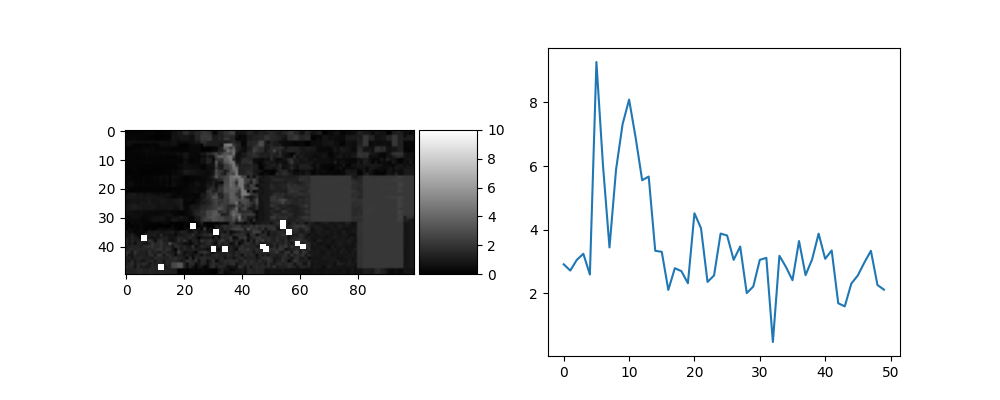

In [74]:


fig,ax = plt.subplots(1,2,figsize=(10, 4))
ax[0].imshow(d2_container[100],cmap="gray",vmin=0, vmax=20)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax_handle,cax=cax)

ax[1].plot(d2_container[99][:,33:34].flatten())

In [ ]:
def get_lines_of_significant_change(threshold=100):
    